In [2]:
import ray
import json
import librosa
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from random import sample
from typing import Optional, Iterable

# Directory containing audio files organized by class
audio_directory = Path("/home/div/vsCode/Audio_classifier_Model/data/urbansound8k_by_class")

# Audio processing parameters
SR = 22050         # Target sample rate for all clips
N_FFT = 2048       # Window size for the STFT
HOP_LENGTH = 512   # Hop length between frames

CLASS_MAP = {
    "0": "air_conditioner",
    "1": "car_horn",
    "2": "children_playing",
    "3": "dog_bark",
    "4": "drilling",
    "5": "engine_idling",
    "6": "gun_shot",
    "7": "jackhammer",
    "8": "siren",
    "9": "street_music",
}

# Container for spectrograms keyed by file path
spectrograms = {}
samples_by_class = {name: [] for name in CLASS_MAP.values()}

In [ ]:
# Output directory for spectrograms
OUTPUT_ROOT = Path("/home/div/vsCode/Audio_classifier_Model/data/urbansound8k_spectrograms") # Directory to save spectrograms, customize if desired
CLASS_SELECTION: Optional[Iterable[str]] = {"dog_bark"}  # to limit processing and testing, set to None to process all classes

ray.init(ignore_reinit_error=True)

@ray.remote
def compute_and_save_spectrogram(path_str: str, dest_dir_str: str):
    path = Path(path_str)
    dest_dir = Path(dest_dir_str)
    dest_dir.mkdir(parents=True, exist_ok=True)

    y, sr = librosa.load(path, sr=SR)
    stft = librosa.stft(y, n_fft=N_FFT, hop_length=HOP_LENGTH)
    spec = np.abs(stft)
    log_spec = librosa.amplitude_to_db(spec, ref=np.max)

    dest_file = dest_dir / f"{path.stem}.npy"
    np.save(dest_file, log_spec, allow_pickle=False)
    return str(dest_file)

selected_dirs = [
    d for d in audio_directory.iterdir()
    if d.is_dir() and (CLASS_SELECTION is None or d.name in CLASS_SELECTION)
]

jobs = []
for class_dir in selected_dirs:
    target_dir = OUTPUT_ROOT / class_dir.name
    for wav_path in class_dir.rglob("*.wav"):
        jobs.append(compute_and_save_spectrogram.remote(str(wav_path), str(target_dir)))

saved_files = ray.get(jobs)
ray.shutdown()

print(f"Saved {len(saved_files)} spectrograms into {OUTPUT_ROOT}")

2025-11-07 16:24:53,483	INFO worker.py:2003 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Saved 1000 spectrograms into /home/div/vsCode/Audio_classifier_Model/data/urbansound8k_spectrograms


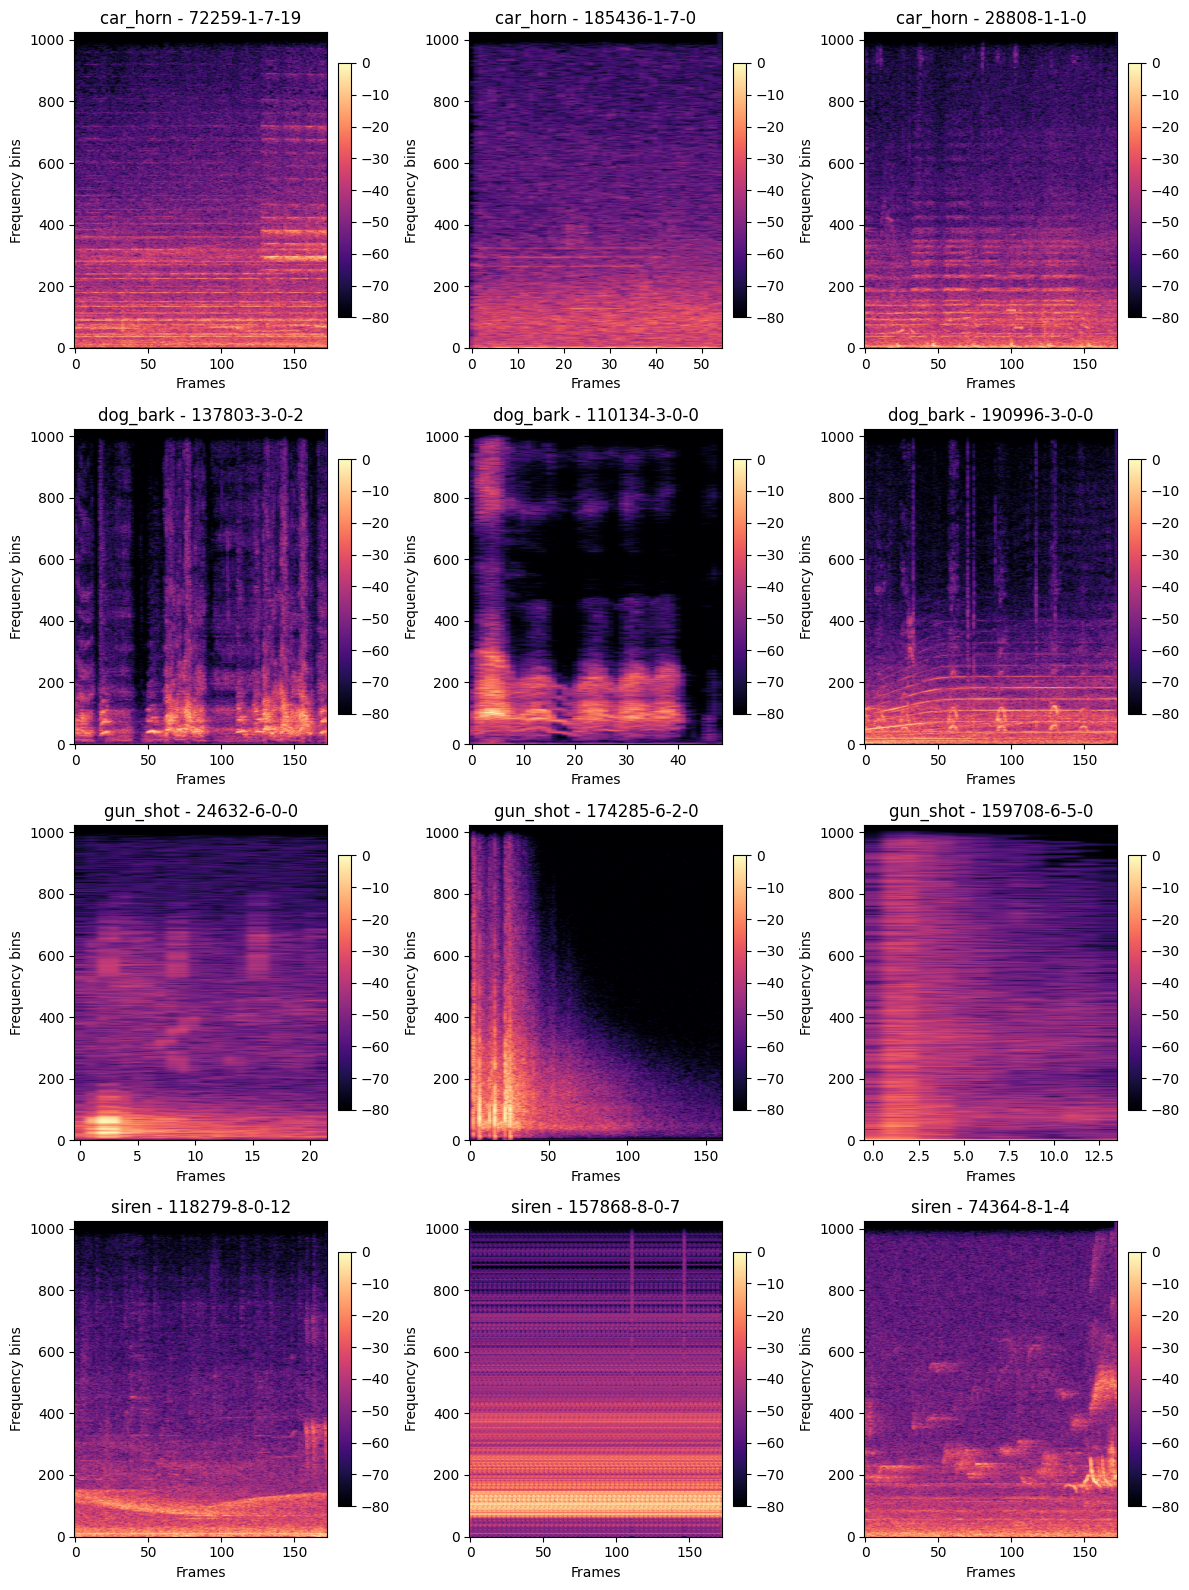

In [ ]:
SPECTRO_ROOT = Path("/home/div/vsCode/Audio_classifier_Model/data/urbansound8k_spectrograms") # path to spectrograms, change if needed
SAMPLES_PER_CLASS = 3  # adjust for more/less slides

clips = []
for class_dir in sorted(SPECTRO_ROOT.iterdir()):
    if not class_dir.is_dir():
        continue
    npy_files = list(class_dir.glob("*.npy"))
    if not npy_files:
        continue
    take = npy_files if len(npy_files) <= SAMPLES_PER_CLASS else sample(npy_files, SAMPLES_PER_CLASS)
    clips.extend((class_dir.name, path.stem, np.load(path)) for path in take)

ncols = 3
nrows = int(np.ceil(len(clips) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4 * nrows))
axes = axes.flatten()

for ax, (label, clip_name, spec) in zip(axes, clips):
    img = ax.imshow(spec, origin="lower", aspect="auto", cmap="magma")
    ax.set_title(f"{label} - {clip_name}")
    ax.set_xlabel("Frames")
    ax.set_ylabel("Frequency bins")
    fig.colorbar(img, ax=ax, fraction=0.046, pad=0.04)

for ax in axes[len(clips):]:
    ax.axis("off")

plt.tight_layout()
plt.show()